Build a predictive model for qualifying lap times that:

- Uses data from multiple seasons (2023–2025), not just one session

- Incorporates circuit characteristics, driver performance, and environmental factors

- Can generalize across circuits and seasons

For each qualifying session:

- Driver, Team

- LapTime, LapNumber, Stint, TyreLife, FreshTyre, Compound

- Sector1Time, Sector2Time, Sector3Time

- TrackTemp, AirTemp

- Year and circuit location

Custom circuit information (your CSV)

- Static circuit descriptors:
TrackLength, NumTurns, RaceDistance, NumLaps, TyreStress,
AsphaltGrip, Downforce, Braking, LateralLoad, etc.

- Pirelli tyre choices: Soft, Medium, Hard (mapped to C1–C6 scale)

https://chatgpt.com/share/68f66629-4ab4-800d-8cda-b55eed216896

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
FILE_2025 = 'features_laps_2025.csv'
FILE_2024 = 'features_laps_2024.csv'
FILE_2023 = 'features_laps_2023.csv'

In [17]:
features_25 = pd.read_csv(FILE_2025, delimiter=',')
features_24 = pd.read_csv(FILE_2024, delimiter=',')
features_23 = pd.read_csv(FILE_2023, delimiter=',')

In [18]:
features = pd.concat([features_25, features_24, features_23], ignore_index=True)

In [19]:
remove_2025 = ['Austin', 'Mexico City', 'São Paulo', 'Las Vegas', 'Lusail', 'Yas Island']

features = features[~((features['Year'] == 2025) & (features['Location'].isin(remove_2025)))]

In [20]:
features['Year'].value_counts()

Year
2023    2309
2024    2285
2025    1679
Name: count, dtype: int64

In [21]:
features.to_csv('features_laps.csv', index=False)

## Encoding

In [22]:
features_encoded = pd.get_dummies(features, columns=['Driver','Team','Location'], drop_first=False)

In [23]:
def map_compound(row):
    if row['Compound'] == 'SOFT':
        return row['Soft']
    elif row['Compound'] == 'MEDIUM':
        return row['Medium']
    elif row['Compound'] == 'HARD':
        return row['Hard']
    else:
        return None
    
features_encoded['Compound'] = features_encoded.apply(map_compound, axis=1)

compound_map = {'C6' : 6, 'C5' : 5, 'C4' : 4, 'C3' : 3, 'C2' : 2, 'C1' : 1} # wet = 0
features_encoded['Compound'] = features_encoded['Compound'].map(compound_map).fillna(0)

In [24]:
features_encoded = features_encoded.drop(columns=['Country','EventDate','EventName','Soft','Medium','Hard'])

In [25]:
features_encoded.loc[features_encoded['TyreLife'].isna() & (features_encoded['FreshTyre'] == True), 'TyreLife'] = 2.0
features_encoded.loc[features_encoded['TyreLife'].isna() & (features_encoded['FreshTyre'] == False), 'TyreLife'] = 3.0

In [26]:
nan_summary = features_encoded.isna().sum()
nan_summary = nan_summary[nan_summary > 0]
print(nan_summary)

Series([], dtype: int64)


In [27]:
features_encoded.to_csv('features_laps_encoded.csv', index=False)

In [28]:
features_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6273 entries, 0 to 6752
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LapTime                     6273 non-null   float64
 1   LapNumber                   6273 non-null   float64
 2   Stint                       6273 non-null   float64
 3   TyreLife                    6273 non-null   float64
 4   FreshTyre                   6273 non-null   bool   
 5   Compound                    6273 non-null   float64
 6   TrackTemp                   6273 non-null   float64
 7   AirTemp                     6273 non-null   float64
 8   Sector1Time                 6273 non-null   float64
 9   Sector2Time                 6273 non-null   float64
 10  Sector3Time                 6273 non-null   float64
 11  Year                        6273 non-null   int64  
 12  TrackLenght                 6273 non-null   float64
 13  NumTurns                    6273 non-n

## Load files

In [29]:
FEATURES_FILE = "features_laps.csv"
features = pd.read_csv(FEATURES_FILE, delimiter=',')

In [30]:
FEATURES_ENCODED_FILE = "features_laps_encoded.csv"
features_encoded = pd.read_csv(FEATURES_ENCODED_FILE, delimiter=',')

## Model Training and Evaluation

In [31]:
from sklearn.preprocessing import StandardScaler

### Predict the lap time directly from random laps

In [32]:
from sklearn.model_selection import train_test_split

X = features_encoded.drop(columns=['LapTime'])
y = features_encoded['LapTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.117 seconds
RMSE: 0.256 seconds


In [ ]:
pred_df = X_test.copy()  # copy the features used for prediction
pred_df['ActualLapTime'] = y_test.values
pred_df['PredictedLapTime'] = y_pred
pred_df['Driver'] = features.loc[X_test.index, 'Driver']
pred_df['Team'] = features.loc[X_test.index, 'Team']
pred_df['Location'] = features.loc[X_test.index, 'Location']


cols_to_keep = ['Driver', 'Team', 'LapNumber', 'Stint', 'Compound', 
                'PredictedLapTime', 'ActualLapTime', 'Location', 'Year']
pred_df = pred_df[cols_to_keep]

In [ ]:
pred_df_sorted = pred_df.sort_values(by=['Year', 'Location', 'PredictedLapTime'])

In [37]:
pred_df_diff = pred_df.copy()
pred_df_diff['Difference'] = pred_df_diff['ActualLapTime'] - pred_df_diff['PredictedLapTime']

# Add a column for absolute difference
pred_df_diff['AbsDifference'] = pred_df_diff['Difference'].abs()

# Sort by absolute difference
pred_df_diff_sorted = pred_df_diff.sort_values(by='AbsDifference')

In [38]:
pred_df_diff

,LapNumber,Stint,TyreLife,FreshTyre,Compound,TrackTemp,AirTemp,Sector1Time,Sector2Time,Sector3Time,...,Location_São Paulo,Location_Yas Island,Location_Zandvoort,ActualLapTime,PredictedLapTime,Driver,Team,Location,Difference,AbsDifference
3163,18.0,5.0,2.0,True,4.0,28.6,24.4,24.217,25.128,21.512,...,False,False,True,70.857,70.81363,STR,Aston Martin,Zandvoort,0.04337,0.04337
1893,5.0,2.0,2.0,True,3.0,26.7,17.7,31.676,40.394,17.751,...,False,False,False,89.821,89.72945,HUL,Haas F1 Team,Suzuka,0.09155,0.09155
3690,5.0,1.0,5.0,True,5.0,14.7,12.4,26.804,31.677,36.361,...,False,False,False,94.842,94.78228,LAW,RB,Las Vegas,0.05972,0.05972
1703,5.0,1.0,5.0,True,5.0,35.0,18.8,26.991,17.944,33.253,...,False,False,False,78.188,78.10452,ZHO,Kick Sauber,Melbourne,0.08348,0.08348
5210,19.0,5.0,2.0,True,4.0,24.8,22.0,27.913,35.539,24.393,...,False,False,False,87.845,87.84394,PIA,McLaren,Silverstone,0.00106,0.00106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,9.0,2.0,9.0,False,5.0,29.5,24.0,28.564,27.918,21.783,...,False,False,False,78.265,78.23511,SAI,Ferrari,Budapest,0.02989,0.02989
2759,17.0,6.0,5.0,False,5.0,45.1,31.2,16.431,29.374,19.699,...,False,False,False,65.504,65.41363,PER,Red Bull Racing,Spielberg,0.09037,0.09037
5241,15.0,5.0,3.0,True,4.0,23.8,20.0,32.967,49.162,30.064,...,False,False,False,112.193,111.74204,STR,Aston Martin,Spa-Francorchamps,0.45096,0.45096
106,4.0,2.0,2.0,True,4.0,39.6,26.1,24.497,27.383,39.944,...,False,False,False,91.824,91.64044,HAD,Racing Bulls,Shanghai,0.18356,0.18356


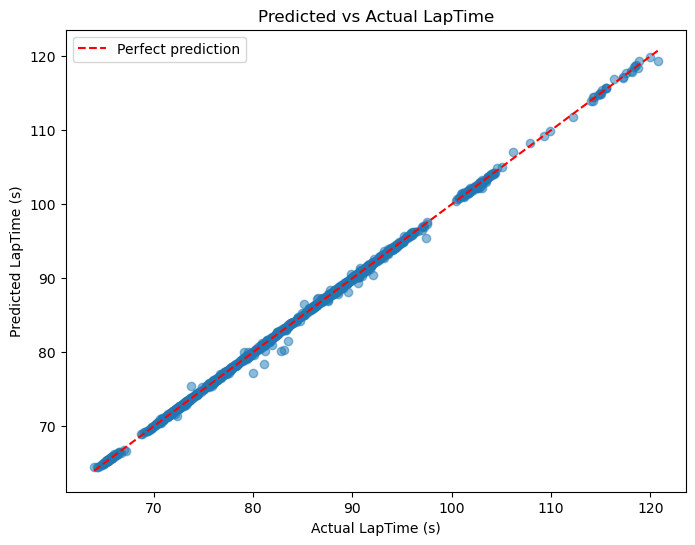

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual LapTime (s)')
plt.ylabel('Predicted LapTime (s)')
plt.title('Predicted vs Actual LapTime')
plt.legend()
plt.show()

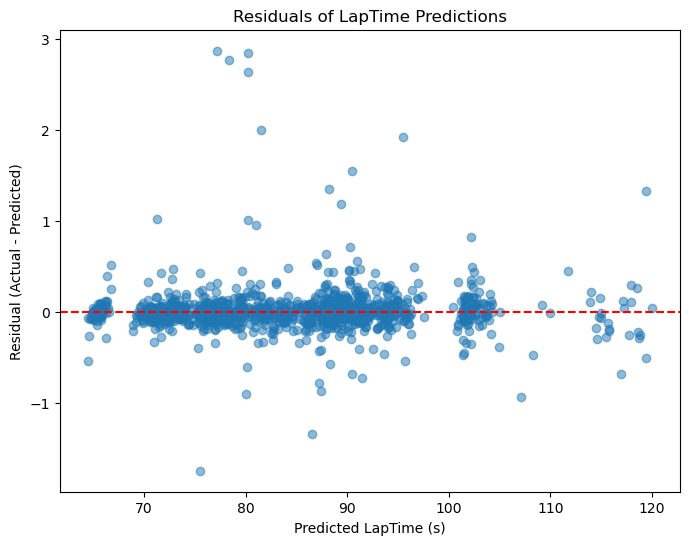

In [40]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted LapTime (s)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals of LapTime Predictions')
plt.show()

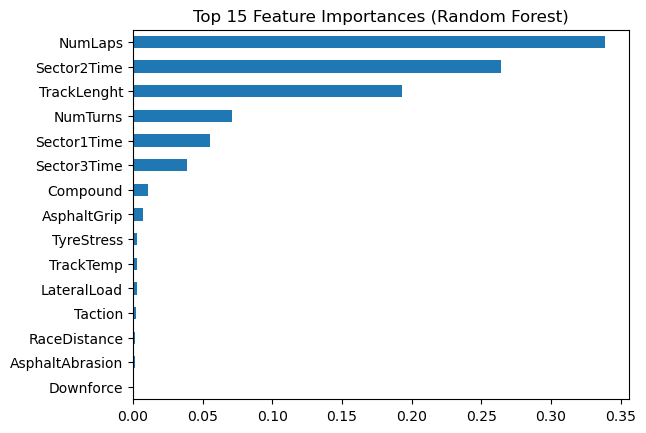

In [45]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [48]:
importances.nlargest(15)

TrackLenght                   0.141630
NumLaps                       0.128096
Sector2Time                   0.127968
Sector1Time                   0.092581
Sector3Time                   0.068532
NumTurns                      0.059297
RaceDistance                  0.047008
Location_Spa-Francorchamps    0.034474
TrackTemp                     0.032308
Braking                       0.024849
Compound                      0.024670
Taction                       0.023818
Downforce                     0.023650
LateralLoad                   0.017410
AsphaltGrip                   0.015951
dtype: float64

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators' : [100, 200, 400],
    'max_depth' : [10, 20, 30 , None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : ['sqrt', 'log2']
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best parameters: ", grid_search.best_params_)




Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4

In [44]:
best_rf = RandomForestRegressor(
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)
preds = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.158 seconds
RMSE: 0.281 seconds


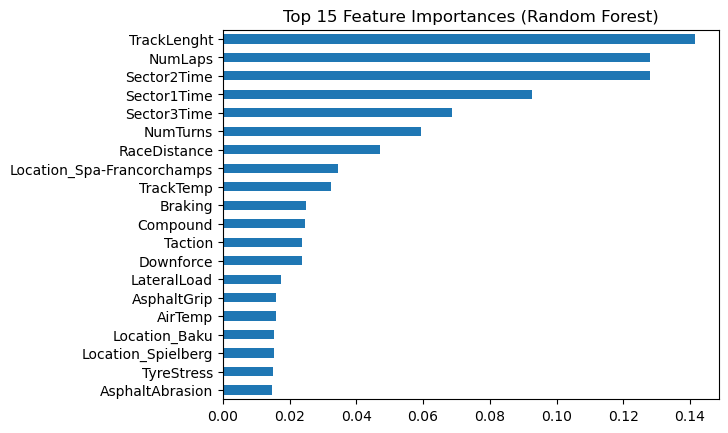

In [47]:
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [49]:
importances.nlargest(20)


TrackLenght                   0.141630
NumLaps                       0.128096
Sector2Time                   0.127968
Sector1Time                   0.092581
Sector3Time                   0.068532
NumTurns                      0.059297
RaceDistance                  0.047008
Location_Spa-Francorchamps    0.034474
TrackTemp                     0.032308
Braking                       0.024849
Compound                      0.024670
Taction                       0.023818
Downforce                     0.023650
LateralLoad                   0.017410
AsphaltGrip                   0.015951
AirTemp                       0.015762
Location_Baku                 0.015363
Location_Spielberg            0.015290
TyreStress                    0.014944
AsphaltAbrasion               0.014758
dtype: float64

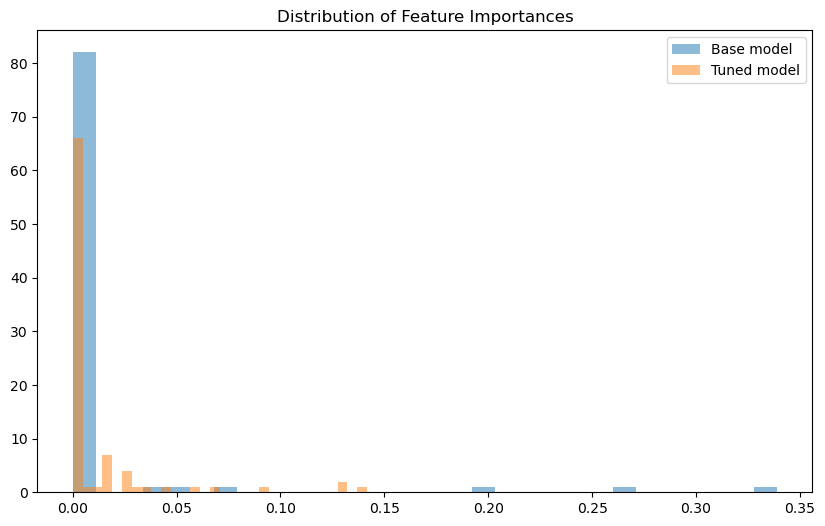

In [50]:
feat_imp_base = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp_best = pd.Series(best_rf.feature_importances_, index=X_train.columns)

plt.figure(figsize=(10,6))
plt.hist(feat_imp_base[feat_imp_base>0], bins=30, alpha=0.5, label='Base model')
plt.hist(feat_imp_best[feat_imp_best>0], bins=30, alpha=0.5, label='Tuned model')
plt.legend()
plt.title("Distribution of Feature Importances")
plt.show()

In [60]:
best_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=30,          # smaller trees
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)
preds = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.158 seconds
RMSE: 0.281 seconds


## FIxing data leaks

In [78]:
X_train_mod = X_train.copy()
X_test_mod = X_test.copy()

X_train_mod = X_train_mod.drop(columns=['RaceDistance', 'NumLaps', 'LapNumber', 'TyreLife', 'FreshTyre', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time'])
X_test_mod = X_test_mod.drop(columns=['RaceDistance', 'NumLaps', 'LapNumber', 'TyreLife', 'FreshTyre', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time'])


rf_mod = RandomForestRegressor(
    n_estimators=400,
    max_depth=30,          # smaller trees
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_mod.fit(X_train_mod, y_train)
preds = rf_mod.predict(X_test_mod)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")


MAE: 0.432 seconds
RMSE: 0.648 seconds


In [79]:
X_train_mod

,Compound,TrackTemp,AirTemp,Year,TrackLenght,NumTurns,Taction,AsphaltGrip,AsphaltAbrasion,TrackEvolution,...,Location_Monza,Location_Sakhir,Location_Shanghai,Location_Silverstone,Location_Spa-Francorchamps,Location_Spielberg,Location_Suzuka,Location_São Paulo,Location_Yas Island,Location_Zandvoort
1335,4.0,34.2,20.5,2025,4.259,14,3,3,3,4,...,False,False,False,False,False,False,False,False,False,True
1443,5.0,43.9,26.8,2025,5.793,11,3,3,2,4,...,True,False,False,False,False,False,False,False,False,False
952,6.0,41.3,21.2,2025,4.361,14,4,2,1,5,...,False,False,False,False,False,False,False,False,False,False
2977,0.0,22.4,17.9,2024,7.004,19,4,3,3,3,...,False,False,False,False,True,False,False,False,False,False
1951,3.0,21.7,18.1,2024,5.412,15,4,3,5,4,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,5.0,13.6,11.5,2024,6.201,17,2,1,2,5,...,False,False,False,False,False,False,False,False,False,False
5191,4.0,23.7,21.3,2023,5.891,18,3,4,2,2,...,False,False,False,True,False,False,False,False,False,False
5226,4.0,23.7,22.2,2023,5.891,18,3,4,2,2,...,False,False,False,True,False,False,False,False,False,False
5390,4.0,23.8,18.9,2023,4.259,14,3,3,3,4,...,False,False,False,False,False,False,False,False,False,True


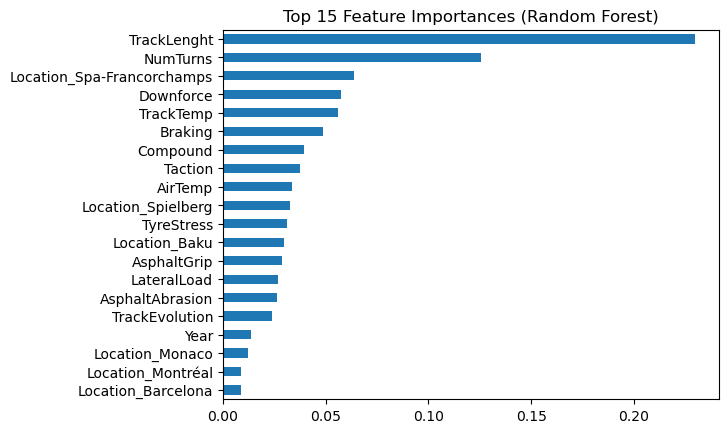

In [80]:
importances = pd.Series(rf_mod.feature_importances_, index=X_train_mod.columns)
importances.nlargest(20).plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators' : [200, 400, 800],
    'max_depth' : [10, 20, 30 , None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : ['sqrt', 'log2', 0.5]
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2
)

grid_search.fit(X_train_mod, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best parameters: ", grid_search.best_params_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=8

In [82]:
print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
Best MAE: 0.4040286195436094


In [83]:
best_rf_mod = RandomForestRegressor(
    n_estimators=800,
    max_depth=None,          # smaller trees
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

best_rf_mod.fit(X_train_mod, y_train)

RandomForestRegressor(max_features=0.5, n_estimators=800, n_jobs=-1,
                      random_state=42)

In [84]:
preds = best_rf_mod.predict(X_test_mod)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.363 seconds
RMSE: 0.559 seconds


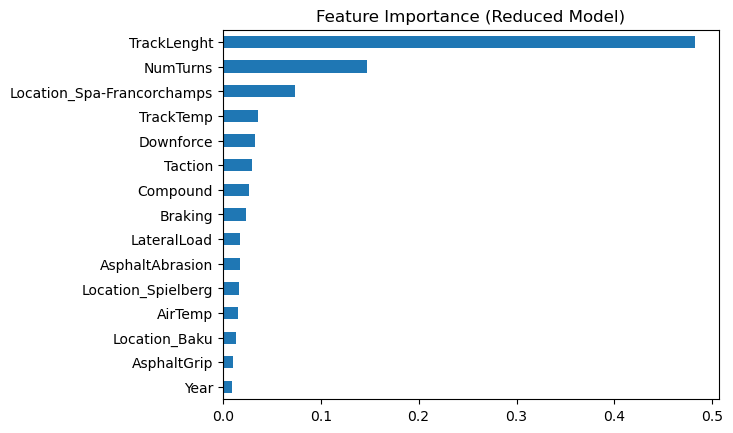

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

feat_imp = pd.Series(best_rf_mod.feature_importances_, index=X_train_mod.columns)
feat_imp.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Feature Importance (Reduced Model)')
plt.gca().invert_yaxis()
plt.show()

In [87]:
feat_imp.nlargest(20)


TrackLenght                   0.482788
NumTurns                      0.146936
Location_Spa-Francorchamps    0.073663
TrackTemp                     0.035326
Downforce                     0.032231
Taction                       0.030002
Compound                      0.026438
Braking                       0.023622
LateralLoad                   0.017172
AsphaltAbrasion               0.016980
Location_Spielberg            0.016164
AirTemp                       0.015105
Location_Baku                 0.013816
AsphaltGrip                   0.010173
Year                          0.009234
TyreStress                    0.006891
TrackEvolution                0.006710
Location_Melbourne            0.005446
Location_Lusail               0.004962
Location_Yas Island           0.004668
dtype: float64

In [89]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

models = {
    "RandomForest": RandomForestRegressor(n_estimators=800, max_depth=None, max_features=0.5, random_state=42, n_jobs=-1),
    "Ridge": Ridge(alpha=1.0),
    "SVR": SVR(kernel='rbf', C=10, epsilon=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "GBR": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_mod, y_train)
    preds = model.predict(X_test_mod)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name:15} → MAE: {mae:.3f}s | RMSE: {rmse:.3f}s")

RandomForest    → MAE: 0.363s | RMSE: 0.559s
Ridge           → MAE: 1.469s | RMSE: 2.170s
SVR             → MAE: 8.676s | RMSE: 10.640s
KNN             → MAE: 0.473s | RMSE: 0.677s


c:\Users\lucam\anaconda3\envs\myenv_mlf1\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\lucam\anaconda3\envs\myenv_mlf1\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\lucam\anaconda3\envs\myenv_mlf1\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lucam\anaconda3\envs\myenv_mlf1\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\lucam\anaconda3\envs\myenv_mlf1\Lib\subpr

GBR             → MAE: 0.411s | RMSE: 0.594s


In [90]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': [None, 0.8, 'sqrt']
}

grid = GridSearchCV(
    gbr, 
    param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=3, 
    n_jobs=-1, 
    verbose=2
    )

grid.fit(X_train_mod, y_train)

print("Best params:", grid.best_params_)
print("Best MAE:", -grid.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best params: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 800}
Best MAE: 0.3887832050906304


In [91]:
best_gbr = GradientBoostingRegressor(
    n_estimators=800, 
    learning_rate=0.05, 
    max_depth=7,
    max_features=0.8,
    min_samples_leaf=3,
    min_samples_split=2,
    random_state=42
    )

best_gbr.fit(X_train_mod, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=7, max_features=0.8,
                          min_samples_leaf=3, n_estimators=800,
                          random_state=42)

In [92]:
preds_gbr = best_gbr.predict(X_test_mod)

mae = mean_absolute_error(y_test, preds_gbr)
rmse = np.sqrt(mean_squared_error(y_test, preds_gbr))
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.352 seconds
RMSE: 0.541 seconds


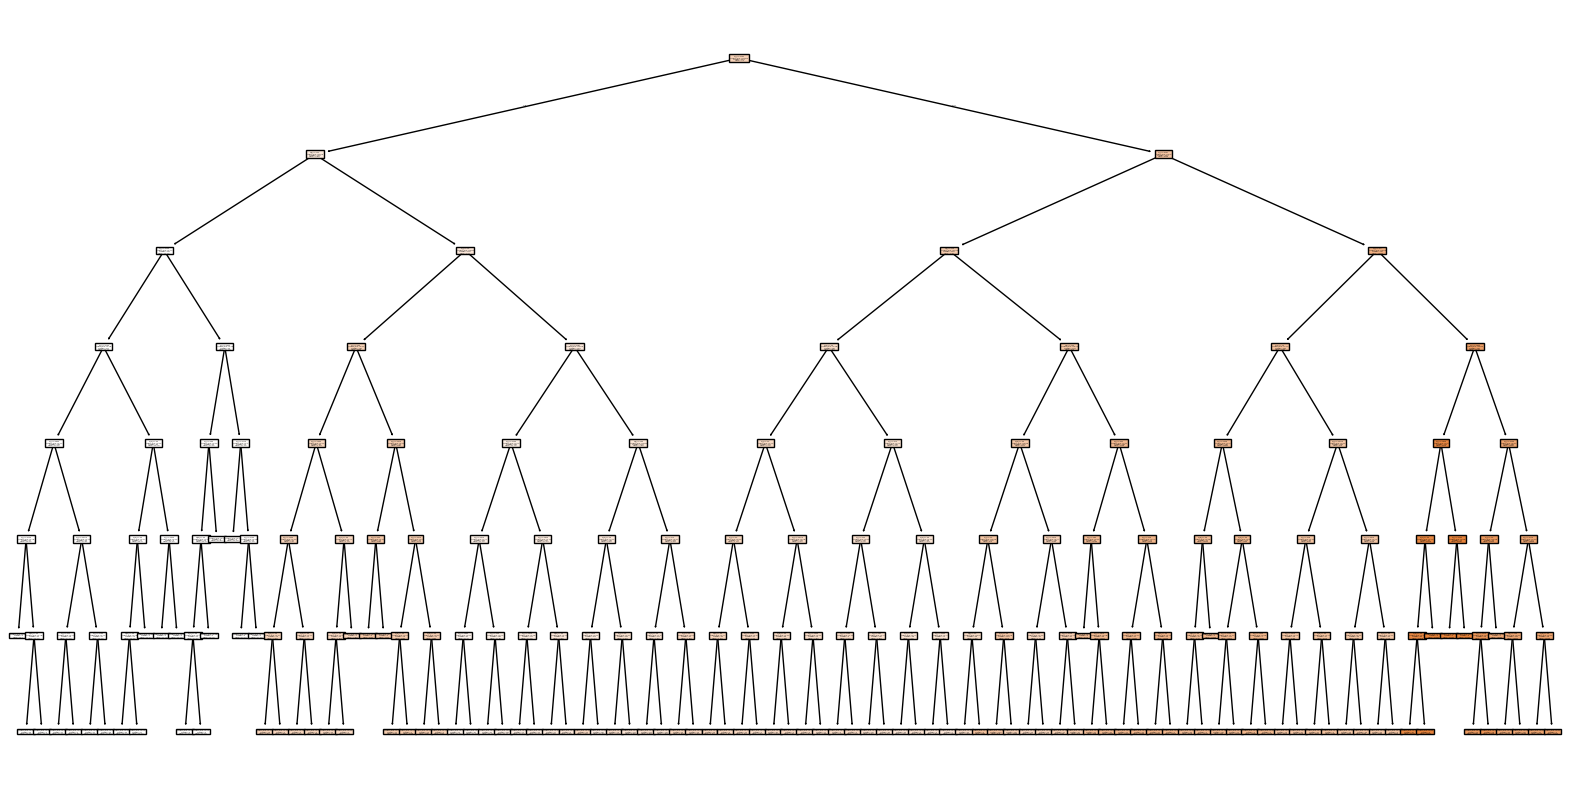

In [99]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(best_gbr.estimators_[0,0], filled=True)  # first tree in the first stage
plt.show()

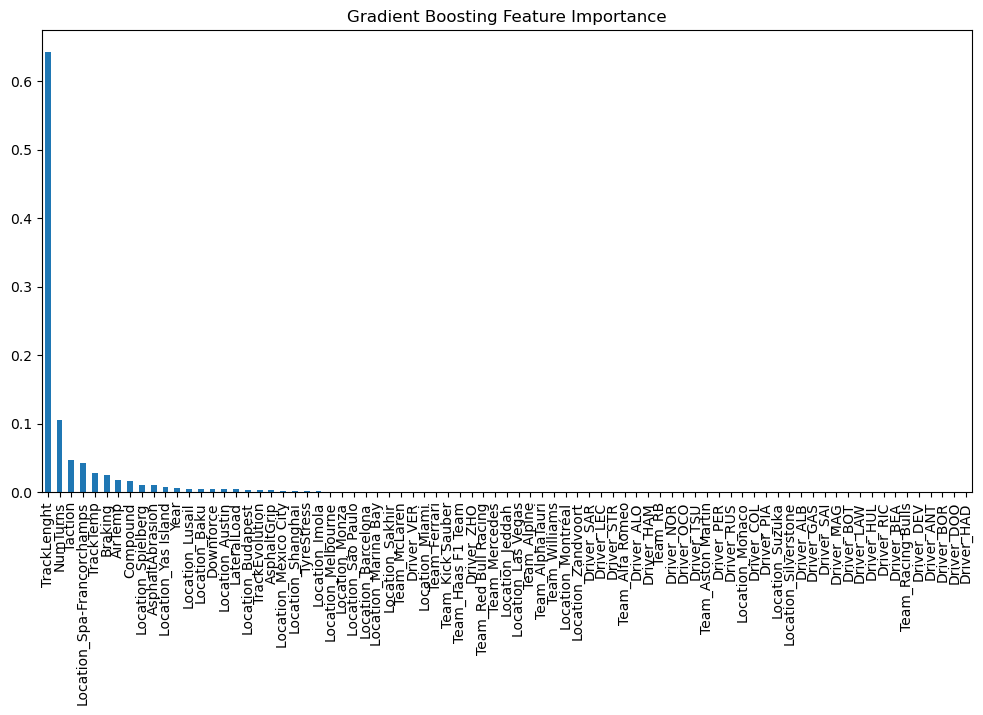

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = pd.Series(best_gbr.feature_importances_, index=X_train_mod.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.title("Gradient Boosting Feature Importance")
plt.show()

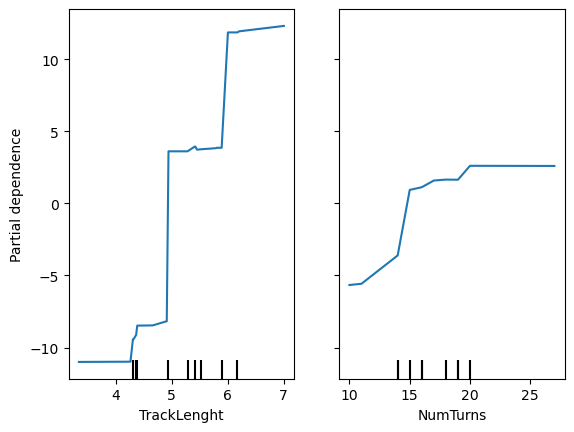

In [104]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# visualize partial dependence for 'TrackLenght' and 'NumTurns'
features_to_plot = ['TrackLenght', 'NumTurns']

PartialDependenceDisplay.from_estimator(best_gbr, X_train_mod, features_to_plot, grid_resolution=50)
plt.show()

In [94]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_mod, y_train)
y_pred_xgb = xgb.predict(X_test_mod)

mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.358 seconds
RMSE: 0.563 seconds


In [95]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,          # same as max_features in sklearn
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_mod, y_train)
y_pred_xgb = xgb.predict(X_test_mod)

mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 0.355 seconds
RMSE: 0.550 seconds


In [96]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [600, 800, 1000],
    'learning_rate': [0.05, 0.03],
    'max_depth': [6, 7, 8],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0.8, 1.0, 1.2],
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train_mod, y_train)
print("Best params:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

AttributeError: 'super' object has no attribute '__sklearn_tags__'